# Mixed logit with ARD

We begin by performing the necessary imports:

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import sys
sys.path.insert(0, "/home/rodr/code/amortized-mxl-dev/release") 

import logging
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Fix random seed for reproducibility
np.random.seed(42)

## Generate simulated data

For this demo, we generate simulated choice data, but we will set one of the fixed effects parameters and one of the random effects parameters to zero, such that their associatied attributes are irrelevant for the utilities.

Other that that, the simulated data is generated in a similar way to the "Mixed logit with simulated data" demo. We predefine the fixed effects parameters (true_alpha) and random effects parameters (true_beta), as well as the covariance matrix (true_Omega), and sample simulated choice data for 2000 respondents (num_resp), each with 5 choice situations (num_menus). The number of choice alternatives is set to 5. 

In [2]:
from core.dcm_fakedata import generate_fake_data_wide

num_resp = 2000
num_menus = 5
num_alternatives = 5

# one of the parameters is set to zero such that the corresponding input variables  
# is not correlated with the observed choices
true_alpha = np.array([-0.8, 0.8, 0]) 
true_beta = np.array([-0.8, 0.8, 1.0, -0.8, 0])
# dynamic version of generating Omega
corr = 0.8
scale_factor = 1.0
true_Omega = corr*np.ones((len(true_beta),len(true_beta))) # off-diagonal values of cov matrix
true_Omega[np.arange(len(true_beta)), np.arange(len(true_beta))] = 1.0 # diagonal values of cov matrix
true_Omega *= scale_factor

df = generate_fake_data_wide(num_resp, num_menus, num_alternatives, true_alpha, true_beta, true_Omega)
df.head()

Generating fake data...
Error: 42.18


ALT1_XF1  ALT1_XF2  ALT1_XF3  ALT1_XR1  ALT1_XR2  ALT1_XR3  ALT1_XR4  \
0  0.374540  0.950714  0.731994  0.069212  0.585697  0.798869  0.764473   
1  0.183405  0.304242  0.524756  0.257912  0.040451  0.793656  0.995865   
2  0.607545  0.170524  0.065052  0.588614  0.571589  0.402953  0.482491   
3  0.662522  0.311711  0.520068  0.946478  0.618740  0.459393  0.860055   
4  0.388677  0.271349  0.828738  0.790511  0.806431  0.767619  0.075828   

   ALT1_XR5  ALT2_XF1  ALT2_XF2  ...  ALT5_XR1  ALT5_XR2  ALT5_XR3  ALT5_XR4  \
0  0.837396  0.598658  0.156019  ...  0.119691  0.938057  0.510089  0.300522   
1  0.956444  0.431945  0.291229  ...  0.107102  0.495835  0.287860  0.651430   
2  0.146977  0.948886  0.965632  ...  0.685591  0.543384  0.531436  0.551352   
3  0.889657  0.546710  0.184854  ...  0.071816  0.562382  0.314172  0.099657   
4  0.110584  0.356753  0.280935  ...  0.174194  0.348183  0.348195  0.824453   

   ALT5_XR5  choice  indID  menuID  obsID  ones  
0  0.624496       0      0       0      0     1  
1  0.145982       2      0       1      1     1  
2  0.486627       2      0       2      2     1  
3  0.190283       3      0       3      3     1  
4  0.496267       3      0       4      4     1  

[5 rows x 45 columns]

## Mixed Logit specification

We now make use of the developed formula interface to specify the utilities of the mixed logit model. 

We begin by defining the fixed effects parameters, the random effects parameters, and the observed variables. This creates instances of Python objects that can be put together to define the utility functions for the different alternatives.

Once the utilities are defined, we collect them in a Python dictionary mapping alternative names to their corresponding expressions.

In [3]:
from core.dcm_interface import FixedEffect, RandomEffect, ObservedVariable
import torch.distributions as dists

# define fixed effects parameters
B_XF1 = FixedEffect('BETA_XF1')
B_XF2 = FixedEffect('BETA_XF2')
B_XF3 = FixedEffect('BETA_XF3')

# define random effects parameters
B_XR1 = RandomEffect('BETA_XR1')
B_XR2 = RandomEffect('BETA_XR2')
B_XR3 = RandomEffect('BETA_XR3')
B_XR4 = RandomEffect('BETA_XR4')
B_XR5 = RandomEffect('BETA_XR5')

# define observed variables
for attr in df.columns:
    exec("%s = ObservedVariable('%s')" % (attr,attr))

# define utility functions
V1 = B_XF1*ALT1_XF1 + B_XF2*ALT1_XF2 + B_XF3*ALT1_XF3 + B_XR1*ALT1_XR1 + B_XR2*ALT1_XR2 + B_XR3*ALT1_XR3 + B_XR4*ALT1_XR4 + B_XR5*ALT1_XR5
V2 = B_XF1*ALT2_XF1 + B_XF2*ALT2_XF2 + B_XF3*ALT2_XF3 + B_XR1*ALT2_XR1 + B_XR2*ALT2_XR2 + B_XR3*ALT2_XR3 + B_XR4*ALT2_XR4 + B_XR5*ALT2_XR5
V3 = B_XF1*ALT3_XF1 + B_XF2*ALT3_XF2 + B_XF3*ALT3_XF3 + B_XR1*ALT3_XR1 + B_XR2*ALT3_XR2 + B_XR3*ALT3_XR3 + B_XR4*ALT3_XR4 + B_XR5*ALT3_XR5
V4 = B_XF1*ALT4_XF1 + B_XF2*ALT4_XF2 + B_XF3*ALT4_XF3 + B_XR1*ALT4_XR1 + B_XR2*ALT4_XR2 + B_XR3*ALT4_XR3 + B_XR4*ALT4_XR4 + B_XR5*ALT4_XR5
V5 = B_XF1*ALT5_XF1 + B_XF2*ALT5_XF2 + B_XF3*ALT5_XF3 + B_XR1*ALT5_XR1 + B_XR2*ALT5_XR2 + B_XR3*ALT5_XR3 + B_XR4*ALT5_XR4 + B_XR5*ALT5_XR5

# associate utility functions with the names of the alternatives
utilities = {"ALT1": V1, "ALT2": V2, "ALT3": V3, "ALT4": V4, "ALT5": V5}

We are now ready to create a Specification object containing the utilities that we have just defined. Note that we must also specify the type of choice model to be used - a mixed logit model (MXL) in this case.

Note that we can inspect the specification by printing the dcm_spec object.

In [4]:
from core.dcm_interface import Specification

# create MXL specification object based on the utilities previously defined
dcm_spec = Specification('MXL', utilities)
print(dcm_spec)

----------------- MXL specification:
Alternatives: ['ALT1', 'ALT2', 'ALT3', 'ALT4', 'ALT5']
Utility functions:
   V_ALT1 = BETA_XF1*ALT1_XF1 + BETA_XF2*ALT1_XF2 + BETA_XF3*ALT1_XF3 + BETA_XR1_n*ALT1_XR1 + BETA_XR2_n*ALT1_XR2 + BETA_XR3_n*ALT1_XR3 + BETA_XR4_n*ALT1_XR4 + BETA_XR5_n*ALT1_XR5
   V_ALT2 = BETA_XF1*ALT2_XF1 + BETA_XF2*ALT2_XF2 + BETA_XF3*ALT2_XF3 + BETA_XR1_n*ALT2_XR1 + BETA_XR2_n*ALT2_XR2 + BETA_XR3_n*ALT2_XR3 + BETA_XR4_n*ALT2_XR4 + BETA_XR5_n*ALT2_XR5
   V_ALT3 = BETA_XF1*ALT3_XF1 + BETA_XF2*ALT3_XF2 + BETA_XF3*ALT3_XF3 + BETA_XR1_n*ALT3_XR1 + BETA_XR2_n*ALT3_XR2 + BETA_XR3_n*ALT3_XR3 + BETA_XR4_n*ALT3_XR4 + BETA_XR5_n*ALT3_XR5
   V_ALT4 = BETA_XF1*ALT4_XF1 + BETA_XF2*ALT4_XF2 + BETA_XF3*ALT4_XF3 + BETA_XR1_n*ALT4_XR1 + BETA_XR2_n*ALT4_XR2 + BETA_XR3_n*ALT4_XR3 + BETA_XR4_n*ALT4_XR4 + BETA_XR5_n*ALT4_XR5
   V_ALT5 = BETA_XF1*ALT5_XF1 + BETA_XF2*ALT5_XF2 + BETA_XF3*ALT5_XF3 + BETA_XR1_n*ALT5_XR1 + BETA_XR2_n*ALT5_XR2 + BETA_XR3_n*ALT5_XR3 + BETA_XR4_n*ALT5_XR4 + BETA_XR5_

Once the Specification is defined, we need to define the DCM Dataset object that goes along with it. For this, we instantiate the Dataset class with the Pandas dataframe containing the data in the so-called "wide format", the name of column in the dataframe containing the observed choices and the dcm_spec that we have previously created.

Note that since this is panel data, we must also specify the name of the column in the dataframe that contains the ID of the respondent (this should be a integer ranging from 0 the num_resp-1).

In [5]:
from core.dcm_interface import Dataset

# create DCM dataset object
dcm_dataset = Dataset(df, 'choice', dcm_spec, resp_id_col='indID')

Preparing dataset...
	Model type: MXL
	Num. observations: 10000
	Num. alternatives: 5
	Num. respondents: 2000
	Num. menus: 5
	Observations IDs: [   0    1    2 ... 9997 9998 9999]
	Alternative IDs: None
	Respondent IDs: [   0    0    0 ... 1999 1999 1999]
	Availability columns: None
	Attribute names: ['ALT1_XF1', 'ALT1_XF2', 'ALT1_XF3', 'ALT1_XR1', 'ALT1_XR2', 'ALT1_XR3', 'ALT1_XR4', 'ALT1_XR5', 'ALT2_XF1', 'ALT2_XF2', 'ALT2_XF3', 'ALT2_XR1', 'ALT2_XR2', 'ALT2_XR3', 'ALT2_XR4', 'ALT2_XR5', 'ALT3_XF1', 'ALT3_XF2', 'ALT3_XF3', 'ALT3_XR1', 'ALT3_XR2', 'ALT3_XR3', 'ALT3_XR4', 'ALT3_XR5', 'ALT4_XF1', 'ALT4_XF2', 'ALT4_XF3', 'ALT4_XR1', 'ALT4_XR2', 'ALT4_XR3', 'ALT4_XR4', 'ALT4_XR5', 'ALT5_XF1', 'ALT5_XF2', 'ALT5_XF3', 'ALT5_XR1', 'ALT5_XR2', 'ALT5_XR3', 'ALT5_XR4', 'ALT5_XR5']
	Fixed effects attribute names: ['ALT1_XF1', 'ALT1_XF2', 'ALT1_XF3', 'ALT2_XF1', 'ALT2_XF2', 'ALT2_XF3', 'ALT3_XF1', 'ALT3_XF2', 'ALT3_XF3', 'ALT4_XF1', 'ALT4_XF2', 'ALT4_XF3', 'ALT5_XF1', 'ALT5_XF2', 'ALT5_XF3']
	Fix

As with the specification, we can inspect the DCM dataset by printing the dcm_dataset object:

In [6]:
print(dcm_dataset)

----------------- DCM dataset:
Model type: MXL
Num. observations: 10000
Num. alternatives: 5
Num. respondents: 2000
Num. menus: 5
Num. fixed effects: 15
Num. random effects: 25
Attribute names: ['ALT1_XF1', 'ALT1_XF2', 'ALT1_XF3', 'ALT1_XR1', 'ALT1_XR2', 'ALT1_XR3', 'ALT1_XR4', 'ALT1_XR5', 'ALT2_XF1', 'ALT2_XF2', 'ALT2_XF3', 'ALT2_XR1', 'ALT2_XR2', 'ALT2_XR3', 'ALT2_XR4', 'ALT2_XR5', 'ALT3_XF1', 'ALT3_XF2', 'ALT3_XF3', 'ALT3_XR1', 'ALT3_XR2', 'ALT3_XR3', 'ALT3_XR4', 'ALT3_XR5', 'ALT4_XF1', 'ALT4_XF2', 'ALT4_XF3', 'ALT4_XR1', 'ALT4_XR2', 'ALT4_XR3', 'ALT4_XR4', 'ALT4_XR5', 'ALT5_XF1', 'ALT5_XF2', 'ALT5_XF3', 'ALT5_XR1', 'ALT5_XR2', 'ALT5_XR3', 'ALT5_XR4', 'ALT5_XR5']


## Bayesian Mixed Logit Model with Automatic Relevance Determination (ARD) in PyTorch

We will perform ARD in the MXL model in a similar way as proposed in: Rodrigues, F., Ortelli, N., Bierlaire, M. and Pereira, F.C., 2020. Bayesian automatic relevance determination for utility function specification in discrete choice models. IEEE Transactions on Intelligent Transportation Systems.

We begin by modifying the generative process of the core MXL model as follows (changes to the MXL model are highlighted in red):
$\require{color}$
1. <font color='red'> Draw variance for prior over fixed taste parameters $\boldsymbol\tau_\alpha \sim \mbox{InverseGamma}(\alpha_0, \beta_0)$ </font>
2. Draw fixed taste parameters $\boldsymbol\alpha \sim \mathcal{N}(\boldsymbol\lambda_0, \color{red} \mbox{diag}(\boldsymbol\tau_\zeta) \color{black})$
3. <font color='red'> Draw variance for prior over random taste parameters $\boldsymbol\tau_\zeta \sim \mbox{InverseGamma}(\alpha_0, \beta_0)$ </font>
4. Draw mean vector $\boldsymbol\zeta \sim \mathcal{N}(\boldsymbol\mu_0, \color{red} \mbox{diag}(\boldsymbol\tau_\zeta) \color{black})$ 
5. Draw scales vector $\boldsymbol\theta \sim \mbox{half-Cauchy}(\boldsymbol\sigma_0)$
6. Draw correlation matrix $\boldsymbol\Psi \sim \mbox{LKJ}(\nu)$
7. For each decision-maker $n \in \{1,\dots,N\}$
    1. Draw random taste parameters $\boldsymbol\beta_n \sim \mathcal{N}(\boldsymbol\zeta,\boldsymbol\Omega)$
    2. For each choice occasion $t \in \{1,\dots,T_n\}$
        1. Draw observed choice $y_{nt} \sim \mbox{MNL}(\boldsymbol\alpha, \boldsymbol\beta_n, \textbf{X}_{nt})$
        
where $\boldsymbol\Omega = \mbox{diag}(\boldsymbol\theta) \times \boldsymbol\Psi \times  \mbox{diag}(\boldsymbol\theta)$.

This model is already implemented in the class ``TorchMXL_ARD``. At the end of this notebook, we provide an explanation of how this extension was implemented. 

We can instantiate this model from the ``TorchMXL_ARD`` using the following code. We can the run variational inference to approximate the posterior distribution of the latent variables in the model. Note that since in this case we know the true parameters that were used to generate the simualated choice data, we can pass them to the "infer" method in order to obtain additional information during the ELBO maximization (useful for tracking the progress of VI and for other debugging purposes). 

[Epoch     0] ELBO: 30651; Loglik: -21061; Acc.: 0.169; Alpha RMSE: 0.645; Beta RMSE: 0.765
[Epoch   100] ELBO: 36925; Loglik: -16834; Acc.: 0.277; Alpha RMSE: 0.265; Beta RMSE: 0.788
[Epoch   200] ELBO: 28090; Loglik: -15822; Acc.: 0.326; Alpha RMSE: 0.091; Beta RMSE: 0.773
[Epoch   300] ELBO: 18901; Loglik: -14839; Acc.: 0.376; Alpha RMSE: 0.048; Beta RMSE: 0.725
[Epoch   400] ELBO: 19277; Loglik: -14460; Acc.: 0.388; Alpha RMSE: 0.086; Beta RMSE: 0.699
[Epoch   500] ELBO: 18957; Loglik: -13972; Acc.: 0.414; Alpha RMSE: 0.082; Beta RMSE: 0.623
[Epoch   600] ELBO: 17863; Loglik: -13922; Acc.: 0.417; Alpha RMSE: 0.068; Beta RMSE: 0.594
[Epoch   700] ELBO: 16851; Loglik: -13622; Acc.: 0.436; Alpha RMSE: 0.073; Beta RMSE: 0.549
[Epoch   800] ELBO: 16725; Loglik: -13468; Acc.: 0.443; Alpha RMSE: 0.124; Beta RMSE: 0.502
[Epoch   900] ELBO: 16681; Loglik: -13089; Acc.: 0.458; Alpha RMSE: 0.101; Beta RMSE: 0.446
[Epoch  1000] ELBO: 16433; Loglik: -13137; Acc.: 0.463; Alpha RMSE: 0.117; Beta 

[Epoch  9000] ELBO: 14775; Loglik: -13415; Acc.: 0.432; Alpha RMSE: 0.056; Beta RMSE: 0.022
[Epoch  9100] ELBO: 14774; Loglik: -13435; Acc.: 0.438; Alpha RMSE: 0.064; Beta RMSE: 0.021
[Epoch  9200] ELBO: 14752; Loglik: -13421; Acc.: 0.444; Alpha RMSE: 0.073; Beta RMSE: 0.023
[Epoch  9300] ELBO: 14797; Loglik: -13464; Acc.: 0.433; Alpha RMSE: 0.057; Beta RMSE: 0.019
[Epoch  9400] ELBO: 14849; Loglik: -13523; Acc.: 0.437; Alpha RMSE: 0.077; Beta RMSE: 0.020
[Epoch  9500] ELBO: 14794; Loglik: -13472; Acc.: 0.438; Alpha RMSE: 0.069; Beta RMSE: 0.020
[Epoch  9600] ELBO: 14820; Loglik: -13505; Acc.: 0.431; Alpha RMSE: 0.063; Beta RMSE: 0.015
[Epoch  9700] ELBO: 14803; Loglik: -13479; Acc.: 0.434; Alpha RMSE: 0.059; Beta RMSE: 0.013
[Epoch  9800] ELBO: 14823; Loglik: -13506; Acc.: 0.433; Alpha RMSE: 0.065; Beta RMSE: 0.018
[Epoch  9900] ELBO: 14842; Loglik: -13523; Acc.: 0.436; Alpha RMSE: 0.078; Beta RMSE: 0.014
[Epoch 10000] ELBO: 14758; Loglik: -13449; Acc.: 0.435; Alpha RMSE: 0.062; Beta 

[Epoch 18000] ELBO: 14697; Loglik: -13468; Acc.: 0.439; Alpha RMSE: 0.051; Beta RMSE: 0.012
[Epoch 18100] ELBO: 14773; Loglik: -13553; Acc.: 0.431; Alpha RMSE: 0.067; Beta RMSE: 0.010
[Epoch 18200] ELBO: 14837; Loglik: -13610; Acc.: 0.422; Alpha RMSE: 0.048; Beta RMSE: 0.014
[Epoch 18300] ELBO: 14815; Loglik: -13585; Acc.: 0.437; Alpha RMSE: 0.072; Beta RMSE: 0.015
[Epoch 18400] ELBO: 14792; Loglik: -13555; Acc.: 0.427; Alpha RMSE: 0.060; Beta RMSE: 0.017
[Epoch 18500] ELBO: 14788; Loglik: -13562; Acc.: 0.434; Alpha RMSE: 0.067; Beta RMSE: 0.020
[Epoch 18600] ELBO: 14728; Loglik: -13493; Acc.: 0.434; Alpha RMSE: 0.059; Beta RMSE: 0.015
[Epoch 18700] ELBO: 14827; Loglik: -13605; Acc.: 0.429; Alpha RMSE: 0.053; Beta RMSE: 0.013
[Epoch 18800] ELBO: 14785; Loglik: -13549; Acc.: 0.432; Alpha RMSE: 0.068; Beta RMSE: 0.012
[Epoch 18900] ELBO: 14805; Loglik: -13567; Acc.: 0.428; Alpha RMSE: 0.056; Beta RMSE: 0.007
[Epoch 19000] ELBO: 14793; Loglik: -13559; Acc.: 0.433; Alpha RMSE: 0.060; Beta 

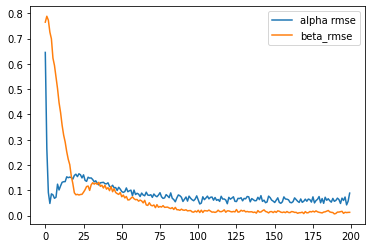

CPU times: user 53min, sys: 2.58 s, total: 53min 3s
Wall time: 5min 7s


In [7]:
%%time

from core.torch_mxl_ard import TorchMXL_ARD

# instantiate MXL model
mxl = TorchMXL_ARD(dcm_dataset, batch_size=num_resp, use_inference_net=False, use_cuda=True)

# run Bayesian inference (variational inference)
results = mxl.infer(num_epochs=20000, true_alpha=true_alpha, true_beta=true_beta)

Lets now have a look at the inferred prior variances. Irrelevant components in the utility will have the expected values of the prior variances of their corresponding parameters shrunk to values close to zero. Starting with the expected values of the prior variances for the fixed effects:

In [8]:
1/(mxl.softplus(mxl.tau_alpha_alpha) / mxl.softplus(mxl.tau_alpha_beta))

tensor([1.0889, 1.0683, 0.0384], device='cuda:0', grad_fn=<MulBackward0>)

We can see that the last preference parameter has a value close to zero, which indicates that the inclusion of that term in the utility function is irrelevant. This is the desired behaviour given the way that the data was generated. 

Lets now have a look at the expected values of the prior variances for the random effects:

In [10]:
1/(mxl.softplus(mxl.tau_zeta_alpha) / mxl.softplus(mxl.tau_zeta_beta))

tensor([1.0584, 1.0380, 1.3097, 1.0221, 0.0225], device='cuda:0',
       grad_fn=<MulBackward0>)

As before, can see that the last preference parameter has a value close to zero, which indicates that the inclusion of that term in the utility function is irrelevant. This is the desired behaviour given the way that the data was generated. 

The "results" dictionary containts a summary of the results of variational inference, including means of the posterior approximations for the different parameters in the model:

In [9]:
results

{'Estimation time': 304.10623359680176,
 'Est. alpha': array([-8.2980311e-01,  8.8909477e-01,  5.0747342e-04], dtype=float32),
 'Est. zeta': array([-0.817338  ,  0.7997669 ,  0.9919458 , -0.81087536, -0.00533627],
       dtype=float32),
 'Est. beta_n': array([[-1.238147  ,  0.35534793,  0.56024605, -0.9264143 , -0.441626  ],
        [-0.5745481 ,  1.3353534 ,  1.3706696 , -0.3979419 ,  0.5681873 ],
        [-1.7197372 , -0.48435944,  0.08551951, -1.7841139 , -0.9252483 ],
        ...,
        [ 0.24848358,  2.0946019 ,  2.317096  ,  0.45183292,  1.5201857 ],
        [-0.81808007,  0.84409773,  1.0342833 , -0.71131504, -0.04303875],
        [-0.6825954 ,  1.1738247 ,  1.2203168 , -0.5835304 ,  0.14842193]],
       dtype=float32),
 'ELBO': 14744.6484375,
 'Loglikelihood': -13506.572265625,
 'Accuracy': 0.43320000171661377}

This interface is currently being improved to include additional output information, but additional information can be obtained from the attributes of the "mxl" object for now. 

## Implementation details

Modifying the core MXL model implementation with this ARD extension is relatively straightforward. The generative process described above is different from the core MXL model, so we begin by introducing the two new priors ($\boldsymbol\tau_\alpha$ and $\boldsymbol\tau_\zeta$) in the ``elbo()`` function:

```python
tau_alpha_prior = td.Gamma(.01*torch.ones(self.num_fixed_params, device=self.device), 
                                   .01*torch.ones(self.num_fixed_params, device=self.device))

tau_zeta_prior = td.Gamma(.01*torch.ones(self.num_mixed_params, device=self.device), 
                          .01*torch.ones(self.num_mixed_params, device=self.device))
```

Note that we use the Gamma distribution, but we will later take the inverse of its samples.

Now we must also change the priors over $\boldsymbol\alpha$ and $\boldsymbol\zeta$ to use the newly defined priors over the variances:

```python
alpha_prior = td.Normal(torch.zeros(self.num_fixed_params, device=self.device), 
                        torch.ones(1, device=self.device)/tau_alpha)

zeta_prior = td.Normal(torch.zeros(self.num_mixed_params, device=self.device),
                               torch.ones(1, device=self.device)/tau_zeta)
```

Our goal is to use Variational Inference to compute (approximate) posterior distributions over $\boldsymbol\tau_\alpha$ and $\boldsymbol\tau_\zeta$. Therefore, we must introduce two new approximate distributions in the ``compute_variational_approximation_q()`` method: $q(\boldsymbol\tau_\alpha)$ and $q(\boldsymbol\tau_\zeta)$. Will use Gamma distributions as the approximate distribution for $\boldsymbol\tau_\alpha$ and $\boldsymbol\tau_\zeta$.

```python
# q(tau_alpha) - construct posterior approximation on tau_alpha
q_tau_alpha = td.Gamma(self.softplus(self.tau_alpha_alpha), self.softplus(self.tau_alpha_beta))

# q(tau_zeta) - construct posterior approximation on tau_zeta
q_tau_zeta = td.Gamma(self.softplus(self.tau_zeta_alpha), self.softplus(self.tau_zeta_beta))
```

Note that these 2 new variational distributions have learnable parameters (we will later optimize the ELBO w.r.t. their values) which we will have to initialize in the ``initialize_variational_distribution_q()`` function:

```python
# q(tau_alpha) - initialize parameters of InverseGamma approximation
self.tau_alpha_alpha = nn.Parameter(-1*torch.ones(self.num_fixed_params))
self.tau_alpha_beta = nn.Parameter(-1*torch.ones(self.num_fixed_params))

# q(tau_zeta) - initialize parameters of InverseGamma approximation
self.tau_zeta_alpha = nn.Parameter(-1*torch.ones(self.num_mixed_params))
self.tau_zeta_beta = nn.Parameter(-1*torch.ones(self.num_mixed_params))
```

At this point, we are almost done. We are just missing updating the ELBO, which now has to include two additional KL terms that result from the two new priors in the generative process: $\mbox{KL}[q(\boldsymbol\tau_\alpha) || p(\boldsymbol\tau_\alpha)]$ and $\mbox{KL}[q(\boldsymbol\tau_\zeta) || p(\boldsymbol\tau_\zeta)]$. We can add these 2 extra terms to the ELBO by including the following 2 lines in the ELBO computation done in by the ``elbo()`` function:

```python
# KL[q(tau_alpha) || p(tau_alpha)]
kld += td.kl_divergence(q_tau_alpha, tau_alpha_prior).sum()

# KL[q(tau_zeta) || p(tau_zeta)]
kld += td.kl_divergence(q_tau_zeta, tau_zeta_prior).sum()
```

And we are done! We have implemented ARD in the core MXL model. After convergence of the ELBO, we can inspect the values of the variational parameters ``self.tau_alpha_alpha``, ``self.tau_alpha_beta``, ``self.tau_zeta_alpha`` and ``self.tau_zeta_beta`` for the results of the ARD selection process as we have done above in this notebook.